# Random Forest Regression (Linear and Second Order with Interaction Terms)

### This notebook fits the house price data using a random forest regression and uses machine learning to predict to predict the house sale price.

In [1]:
# First import relevant libraries:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#### First iteration using a linear model

First fit the data using linear model coefficients. This will use most of the default settings for the RandomForestRegressor.

In [2]:
# Load transformed and normalized data:
train_RF_Lin = pd.read_csv('train_linear.csv')

In [3]:
# Copy train data into new dataframe
train_RF_Lin_iter1 = train_RF_Lin.copy()

In [4]:
# Obtain a list of column names to split the data into X and y
train_RF_Lin_iter1_col_list = train_RF_Lin_iter1.columns.tolist()

# The first column is SalePrice (which is y), so store the remaining columns in a dataframe as X
X_RF_Lin_iter1 = train_RF_Lin_iter1.loc[:,train_RF_Lin_iter1_col_list[1]:train_RF_Lin_iter1_col_list[-1]]
# Now store the first column as y
y_RF_Lin_iter1 = train_RF_Lin_iter1.loc[:,train_RF_Lin_iter1_col_list[0]]
# Split data into training and validation sets:
X_RF_Lin_iter1_train, X_RF_Lin_iter1_validate, y_RF_Lin_iter1_train, y_RF_Lin_iter1_validate = train_test_split(X_RF_Lin_iter1,
                                                                                                                y_RF_Lin_iter1,
                                                                                                                test_size = 0.2,
                                                                                                                random_state = 42,
                                                                                                                shuffle = True)

In [5]:
# The default value for n_estimators used is 100. This is the number of trees in the forest.
# This is too low to accurately fit the data, so it must be increased (that is the same magnitude as the number of features + levels in the data.
# Let's consider several different levels for n_estimators and see how they impact the validation set RMSE
n_estimators_list = [10,25,50,75,100,150,200,250,300,400,500,600,700]
for n_estimators_eval in n_estimators_list:
    model_RF_Lin_eval = RandomForestRegressor(n_estimators = n_estimators_eval, random_state = 42, n_jobs = -1)
    model_RF_Lin_eval.fit(X_RF_Lin_iter1_train, y_RF_Lin_iter1_train)
    y_RF_Lin_eval_valid_predict = model_RF_Lin_eval.predict(X_RF_Lin_iter1_validate)
    RMSE_eval = mean_squared_error(y_RF_Lin_iter1_validate, y_RF_Lin_eval_valid_predict, squared = False)
    RMSE_eval_rounded = round(RMSE_eval, ndigits = 4)
    print(f'With {n_estimators_eval} trees, the validation RMSE was {RMSE_eval_rounded}')

With 10 trees, the validation RMSE was 0.0517
With 25 trees, the validation RMSE was 0.0514
With 50 trees, the validation RMSE was 0.0506
With 75 trees, the validation RMSE was 0.0502
With 100 trees, the validation RMSE was 0.0503
With 150 trees, the validation RMSE was 0.0501
With 200 trees, the validation RMSE was 0.05
With 250 trees, the validation RMSE was 0.05
With 300 trees, the validation RMSE was 0.0501
With 400 trees, the validation RMSE was 0.0501
With 500 trees, the validation RMSE was 0.0498
With 600 trees, the validation RMSE was 0.0498
With 700 trees, the validation RMSE was 0.0499


In [6]:
# I chose to n_estimators = 500 for all of the subsequent analyses.
# The validation RMSE appears to decrease as the number of trees is increased to this value, but does not appear to decrease further beyond it.
# Computational speed was not prohibitively slow with this number of trees either (although it was starting to slow down).

# Now, train & fit the actual model using the training data:
model_RF_Lin_iter1 = RandomForestRegressor(n_estimators = 500, random_state = 13, n_jobs = -1)
model_RF_Lin_iter1.fit(X_RF_Lin_iter1_train, y_RF_Lin_iter1_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=13)

In [7]:
# Define a function to also calculate and print RMSE and R^2 for fits of both the training and validation data
def RMSE_and_R_sq(model_results, X_train, X_validate, y_train, y_validate):
    # training set:
    y_train_predict = model_results.predict(X_train)
    RMSE_train = mean_squared_error(y_train, y_train_predict, squared = False)
    R_squared_train = r2_score(y_train, y_train_predict)
    print('The training set RMSE error is:', round(RMSE_train, ndigits = 4))
    print('The training set R^2 is:', round(R_squared_train, ndigits = 3))
    # validation set:
    y_validate_predict = model_results.predict(X_validate)
    RMSE_validate = mean_squared_error(y_validate, y_validate_predict, squared = False)
    R_squared_validate = r2_score(y_validate, y_validate_predict)
    print('\nThe validation set RMSE error is:', round(RMSE_validate, ndigits = 4))
    print('The validation set R^2 is:', round(R_squared_validate, ndigits = 3))
RMSE_and_R_sq(model_RF_Lin_iter1, X_RF_Lin_iter1_train, X_RF_Lin_iter1_validate, y_RF_Lin_iter1_train, y_RF_Lin_iter1_validate)

The training set RMSE error is: 0.0191
The training set R^2 is: 0.98

The validation set RMSE error is: 0.05
The validation set R^2 is: 0.868


In [8]:
# Define a function to plot model residuals:
def plot_residuals(model_results, X, y, model_type, model_iteration, train_validate):
    resid = y - model_results.predict(X)
    resid_plot = pd.concat([y, resid], axis = 1, ignore_index = True)
    resid_plot = resid_plot.rename(columns = {0:'Actual', 1:'Residual'})
    fig = plt.figure(figsize = [10,8])
    ax = fig.add_subplot()
    ax.scatter(x = resid_plot.Actual, y = resid_plot.Residual)
    ax.set_xlim(left = -0.02, right = 1.02)
    plt.title(f'Random Forest Regression ({model_type}) {model_iteration} {train_validate} SalePrice Residuals',fontsize = 16)
    plt.xlabel('Normalized Actual SalePrice', fontsize = 14)
    plt.ylabel('Residual', fontsize = 14)
    plt.grid(alpha = 0.3)

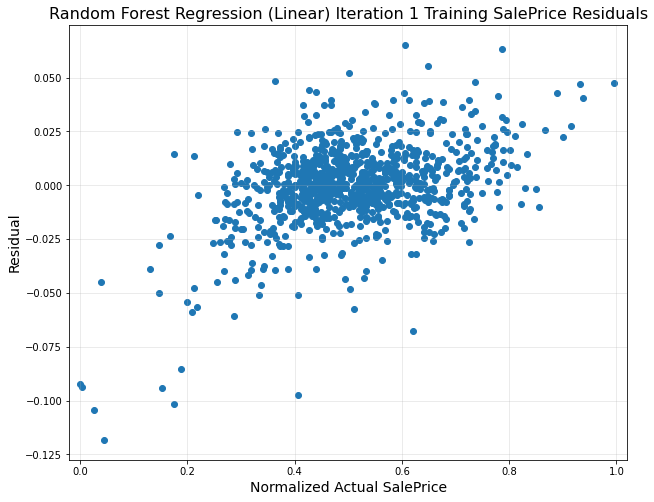

In [9]:
plot_residuals(model_RF_Lin_iter1, X_RF_Lin_iter1_train, y_RF_Lin_iter1_train, 'Linear', 'Iteration 1', 'Training')

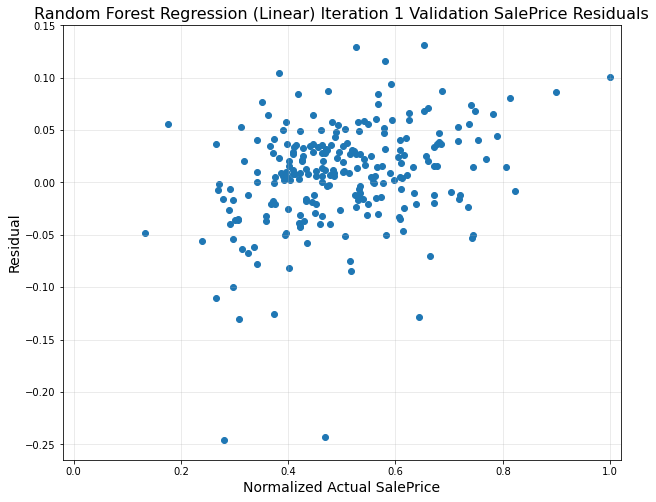

In [10]:
plot_residuals(model_RF_Lin_iter1, X_RF_Lin_iter1_validate, y_RF_Lin_iter1_validate, 'Linear','Iteration 1','Validation')

There is less useable information available from machine learning than regression analysis (e.g. no feature coefficients). Some observations in the areas where there still is overlap:
- The random forest regression fits the training set considerably better than regression; training RMSE was ~0.02 for this untuned random forest compared to ~0.04 for all of the regression iterations. Training set R<sup>2</sup> is also an astonishing 0.98.
- The impressive numbers for the training set aside, the validation set RMSE and R<sup>2</sup> are both similar to the values seen during regression analysis, meaning the random forest is doing a good job fitting the training data, but is not necessarily an improvement when checked with the validation set.
- The residual plots support this conclusion. The residuals from the model fitting (training set) are smaller with the random forest, but there does not appear to be any improvement looking at the residuals from the validation set for the random forest over regression analysis.

#### Second iteration using a linear model

The random forest regressor doesn't look too impressive so far, but the model fit may improve with tuning of hyperparameters

In [11]:
# Copy train data into new dataframe
train_RF_Lin_iter2 = train_RF_Lin.copy()

In [12]:
# Obtain a list of column names to split the data into X and y
train_RF_Lin_iter2_col_list = train_RF_Lin_iter2.columns.tolist()
# The first column is SalePrice (which is y), so store the remaining columns in a dataframe as X
X_RF_Lin_iter2 = train_RF_Lin_iter2.loc[:,train_RF_Lin_iter2_col_list[1]:train_RF_Lin_iter2_col_list[-1]]
# Now store the first column as y
y_RF_Lin_iter2 = train_RF_Lin_iter2.loc[:,train_RF_Lin_iter2_col_list[0]]

In [13]:
# Initialize random forest regressor with the parameter that will be held constant
random_forest = RandomForestRegressor(n_estimators = 500, random_state = 13, n_jobs = -1)

# Set parameter space; below is the initial (coarse) grid that was used to determine the region of interest, followed by a tighter & finer grid

# p_grid = {'max_depth':np.linspace(5,30,6).astype(int),'max_features':np.linspace(10,100,11).astype(int)}
p_grid = {'max_depth':np.linspace(15,25,11).astype(int),'max_features':np.linspace(30,50,11).astype(int)}

# set up k-fold (with 5 folds) cross validation
cross_val_set = KFold(n_splits = 5, shuffle = True, random_state = 13)

In [14]:
# Perform grid search of hyperparameters
grid_search_RF_Lin_iter2 = GridSearchCV(estimator = random_forest,
                                        param_grid = p_grid,
                                        scoring = 'neg_root_mean_squared_error',
                                        n_jobs = -1,
                                        cv = cross_val_set,
                                        return_train_score = True)
grid_search_RF_Lin_iter2.fit(X_RF_Lin_iter2, y_RF_Lin_iter2)

# Store the grid search results in a data frame
grid_results_RF_Lin_iter2 = pd.DataFrame(grid_search_RF_Lin_iter2.cv_results_).sort_values(by = 'rank_test_score', ignore_index = True)

In [15]:
# Define function to make a 3-D plot of the parameter space examined
def plot_grid_parameter(grid_results):
    fig = plt.figure(figsize = [12,8])
    ax = fig.add_subplot(projection = '3d')
    ax.scatter(xs = grid_results.param_max_depth,
               ys = grid_results.param_max_features,
               zs = -grid_results.mean_test_score, # the grid results will output negative RMSE, need to flip the sign
               c = -grid_results.mean_test_score)
    ax.set_xlabel('max_depth')
    ax.set_ylabel('max_features')
    ax.set_zlabel('mean_test_score')

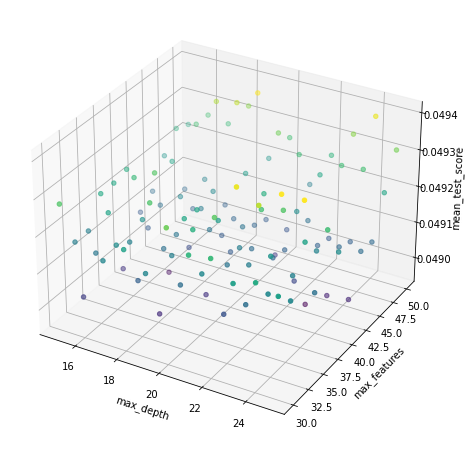

In [16]:
plot_grid_parameter(grid_results_RF_Lin_iter2)

Note that in this parameter space, there appears to be considerably noise in the validation RMSE. In reality though, this appearance is only due to the small range of the z-axis. This indicates that in the region of the local minumum RMSE for these parameters, the response surface is relatively flat.

In [17]:
# Obtain and print the optimal parameters and corresponding training / validation RMSE
grid_max_depth_RF_Lin_iter2 = grid_results_RF_Lin_iter2.loc[0, 'param_max_depth']
grid_max_features_RF_Lin_iter2 = grid_results_RF_Lin_iter2.loc[0,'param_max_features']
train_neg_RMSE_RF_Lin_iter2 = grid_results_RF_Lin_iter2.loc[0,'mean_train_score']
test_neg_RMSE_RF_Lin_iter2 = grid_results_RF_Lin_iter2.loc[0,'mean_test_score']

print('The optimal parameters were:')
print('max_features = ',grid_max_features_RF_Lin_iter2)
print('max_depth = ',grid_max_depth_RF_Lin_iter2)
print('The mean train k-fold RMSE was:',round(-train_neg_RMSE_RF_Lin_iter2, ndigits = 4))
print('The mean validation k-fold RMSE was:',round(-test_neg_RMSE_RF_Lin_iter2, ndigits = 4))

The optimal parameters were:
max_features =  42
max_depth =  23
The mean train k-fold RMSE was: 0.018
The mean validation k-fold RMSE was: 0.049


In [18]:
# Fit the model with the optimal hyperparameters
model_RF_Lin_iter2 = RandomForestRegressor(n_estimators = 500,
                                           max_depth = grid_max_depth_RF_Lin_iter2,
                                           max_features = grid_max_features_RF_Lin_iter2,
                                           random_state = 13)
model_RF_Lin_iter2.fit(X_RF_Lin_iter2, y_RF_Lin_iter2)

RandomForestRegressor(max_depth=23, max_features=42, n_estimators=500,
                      random_state=13)

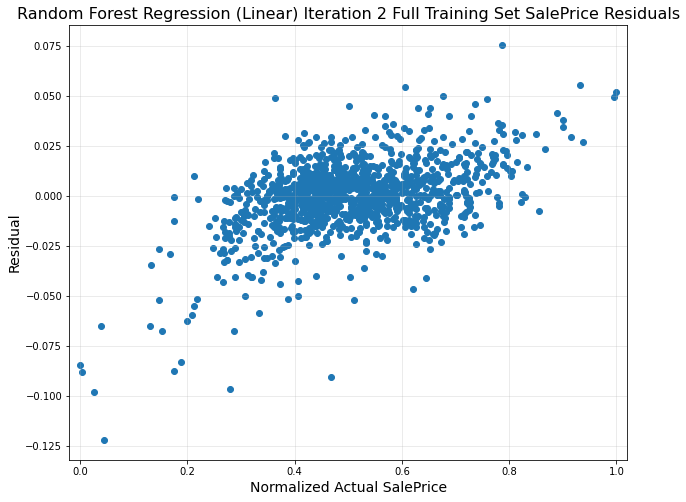

In [19]:
plot_residuals(model_RF_Lin_iter2, X_RF_Lin_iter2, y_RF_Lin_iter2, 'Linear', 'Iteration 2', 'Full Training Set')

The residual plot looks impressive; slightly better than either the untuned random forest model above or the regression analyses. The mean k-fold validation RMSE score was also lower than the untuned model.

#### First iteration using a second order with interaction terms model

The initial modeling was done using linear terms. However, the regression analysis also consider second order and interaction terms. These could be supplied to the random forest regressor to see if they could improve the fit at all.

In [20]:
# Load transformed and normalized data:
train_RF_SOIR = pd.read_csv('train_sec_order.csv')

In [21]:
# Copy train data into new dataframe
train_RF_SOIR_iter1 = train_RF_SOIR.copy()

In [22]:
# Obtain a list of column names to split the data into X and y
train_RF_SOIR_iter1_col_list = train_RF_SOIR_iter1.columns.tolist()
# The first column is SalePrice (which is y), so store the remaining columns in a dataframe as X
X_RF_SOIR_iter1 = train_RF_SOIR_iter1.loc[:,train_RF_SOIR_iter1_col_list[1]:train_RF_SOIR_iter1_col_list[-1]]
# Now store the first column as y
y_RF_SOIR_iter1 = train_RF_SOIR_iter1.loc[:,train_RF_SOIR_iter1_col_list[0]]
# Split data into training and validation sets:
X_RF_SOIR_iter1_train, X_RF_SOIR_iter1_validate, y_RF_SOIR_iter1_train, y_RF_SOIR_iter1_validate = train_test_split(X_RF_SOIR_iter1,
                                                                                                                    y_RF_SOIR_iter1,
                                                                                                                    test_size = 0.2,
                                                                                                                    random_state = 42,
                                                                                                                    shuffle = True)

In [23]:
# Train and fit the model
model_RF_SOIR_iter1 = RandomForestRegressor(n_estimators = 500, random_state = 13, n_jobs = -1)
model_RF_SOIR_iter1.fit(X_RF_SOIR_iter1_train, y_RF_SOIR_iter1_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=13)

In [24]:
RMSE_and_R_sq(model_RF_SOIR_iter1, X_RF_SOIR_iter1_train, X_RF_SOIR_iter1_validate, y_RF_SOIR_iter1_train, y_RF_SOIR_iter1_validate)

The training set RMSE error is: 0.0185
The training set R^2 is: 0.981

The validation set RMSE error is: 0.0495
The validation set R^2 is: 0.87


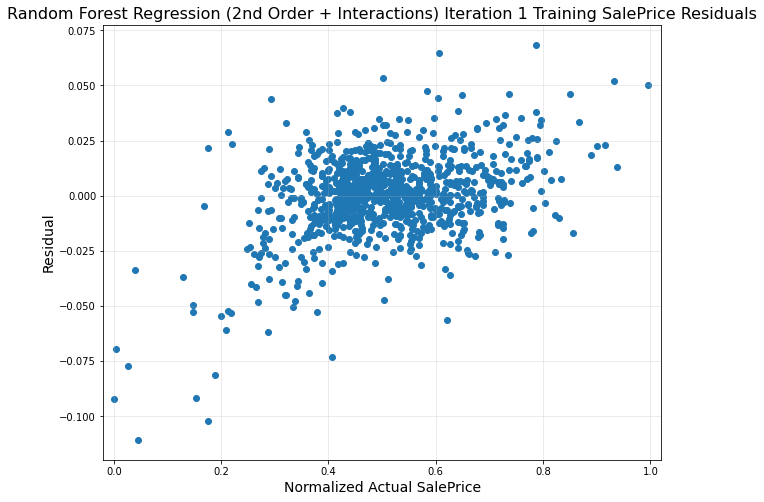

In [25]:
plot_residuals(model_RF_SOIR_iter1, X_RF_SOIR_iter1_train, y_RF_SOIR_iter1_train, '2nd Order + Interactions', 'Iteration 1', 'Training')

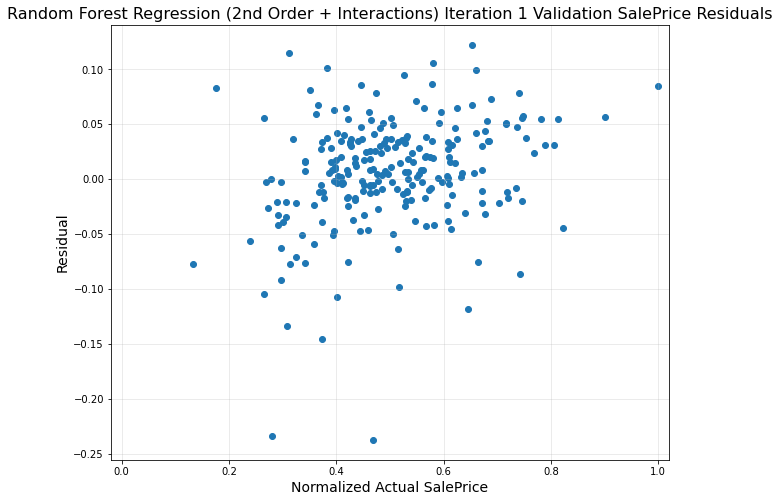

In [26]:
plot_residuals(model_RF_SOIR_iter1, X_RF_SOIR_iter1_validate, y_RF_SOIR_iter1_validate, '2nd Order + Interactions', 'Iteration 1', 'Validation')

There is not much change in the model fit scores (RMSE or R<sup>2</sup>) or the residual plots from adding the higher order terms to the model. However, this is also a fit with only the default settings, so perhaps it can be improved on.

#### Second iteration using a second order with interaction terms model

As with before, let's tune the hyperparameters of the model to see if the fit can be improved.

In [27]:
# Copy train data into new dataframe
train_RF_SOIR_iter2 = train_RF_SOIR.copy()

In [28]:
# Obtain a list of column names to split the data into X and y
train_RF_SOIR_iter2_col_list = train_RF_SOIR_iter2.columns.tolist()
# The first column is SalePrice (which is y), so store the remaining columns in a dataframe as X
X_RF_SOIR_iter2 = train_RF_SOIR_iter2.loc[:,train_RF_SOIR_iter2_col_list[1]:train_RF_SOIR_iter2_col_list[-1]]
# Now store the first column as y
y_RF_SOIR_iter2 = train_RF_SOIR_iter2.loc[:,train_RF_SOIR_iter2_col_list[0]]

In [29]:
# Initialize random forest regressor with the parameter that will be held constant
random_forest = RandomForestRegressor(n_estimators = 500, random_state = 13, n_jobs = -1)

# Set parameter space; below is the initial (coarse) grid that was used to determine the region of interest, followed by a tighter & finer grid

# p_grid = {'max_depth':np.linspace(5,30,6).astype(int),'max_features':np.linspace(10,100,11).astype(int)}
p_grid = {'max_depth':np.linspace(10,20,11).astype(int),'max_features':np.linspace(10,30,11).astype(int)}

# set up k-fold (with 5 folds) cross validation
cross_val_set = KFold(n_splits = 5, shuffle = True, random_state = 13)

In [30]:
# Perform grid search of hyperparameters
grid_search_RF_SOIR_iter2 = GridSearchCV(estimator = random_forest,
                                         param_grid = p_grid,
                                         scoring = 'neg_root_mean_squared_error',
                                         n_jobs = -1,
                                         cv = cross_val_set,
                                         return_train_score = True)
grid_search_RF_SOIR_iter2.fit(X_RF_SOIR_iter2, y_RF_SOIR_iter2)

# Store the grid search results in a data frame
grid_results_RF_SOIR_iter2 = pd.DataFrame(grid_search_RF_SOIR_iter2.cv_results_).sort_values(by = 'rank_test_score', ignore_index = True)

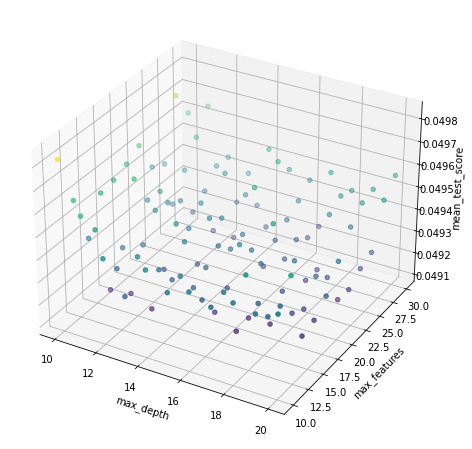

In [31]:
# Plot the parameter space examined
plot_grid_parameter(grid_results_RF_SOIR_iter2)

As was the case with the linear model, there appears to be considerably noise in the validation RMSE. Once again, this is due to the small range of the z-axis. This indicates that in the region of the local minumum RMSE for these parameters, the response surface is relatively flat.

In [32]:
# Obtain and print the optimal parameters and corresponding training / validation RMSE
grid_max_depth_RF_SOIR_iter2 = grid_results_RF_SOIR_iter2.loc[0, 'param_max_depth']
grid_max_features_RF_SOIR_iter2 = grid_results_RF_SOIR_iter2.loc[0,'param_max_features']
train_neg_RMSE_RF_SOIR_iter2 = grid_results_RF_SOIR_iter2.loc[0,'mean_train_score']
test_neg_RMSE_RF_SOIR_iter2 = grid_results_RF_SOIR_iter2.loc[0,'mean_test_score']

print('The optimal parameters were:')
print('max_features = ',grid_max_features_RF_SOIR_iter2)
print('max_depth = ',grid_max_depth_RF_SOIR_iter2)
print('The mean train k-fold RMSE was:',round(-train_neg_RMSE_RF_SOIR_iter2, ndigits = 4))
print('The mean validation k-fold RMSE was:',round(-test_neg_RMSE_RF_SOIR_iter2, ndigits = 4))

The optimal parameters were:
max_features =  24
max_depth =  19
The mean train k-fold RMSE was: 0.0182
The mean validation k-fold RMSE was: 0.0491


In [33]:
# Fit the model with the optimal hyperparameters
model_RF_SOIR_iter2 = RandomForestRegressor(n_estimators = 500,
                                            max_depth = grid_max_depth_RF_SOIR_iter2,
                                            max_features = grid_max_features_RF_SOIR_iter2,
                                            random_state = 13)
model_RF_SOIR_iter2.fit(X_RF_SOIR_iter2, y_RF_SOIR_iter2)

RandomForestRegressor(max_depth=19, max_features=24, n_estimators=500,
                      random_state=13)

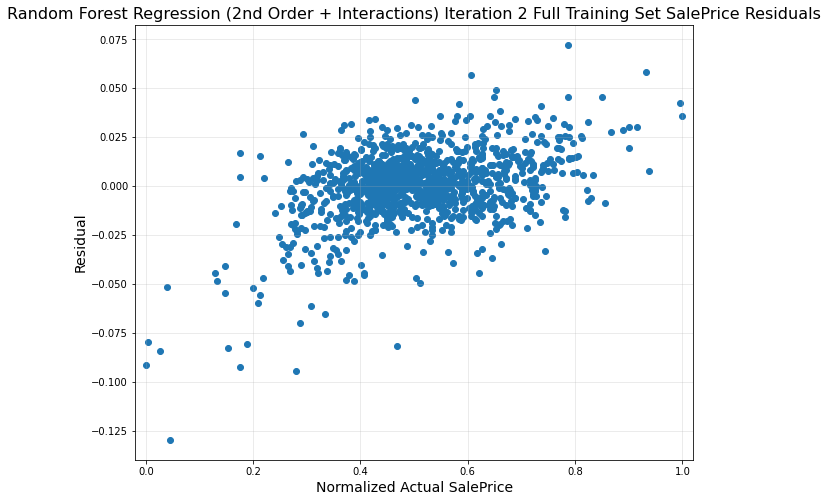

In [34]:
plot_residuals(model_RF_SOIR_iter2, X_RF_SOIR_iter2, y_RF_SOIR_iter2, '2nd Order + Interactions', 'Iteration 2', 'Full Training Set')

The tuned second order with interation terms model has slightly lower validation RMSE than the untuned model, although the difference is quite small. The residual plot again looks fairly similar.

#### Summary of the validation (mean k-fold where appropriate) RMSE and test set scores:

| Model Iteration | Validation Set RMSE | Test Set Score (log RMSE) |
| --- | -: | -: |
| Linear Iteration 1 | 0.0500 | 0.15638 |
| Linear Iteration 2 | 0.0490 | 0.15116 |
| 2nd Order + Interactions Iteration 1 | 0.0495 | 0.14938 |
| 2nd Order + Interactions Iteration 2 | 0.0491 | 0.15069 |

The test set scores are obtained from submitting predicted values for sale price for the data in the test data set on Kaggle.

Other than the untuned linear random forest model, these validation and test RMSE scores are lower (and therefore better) than the score observed using regression analysis. Again there is some disagreement between directional moves in the evaluation with the validation set and the test set. Visualizations of the hyperparameter tuning space suggest this may be due to the model fit evaluation is relatively "flat" with respect to changing parameters, so that random error might be significant. Nonetheless, it is clear that a tuned linear model is better than one that has not been tuned, and that the inclusion of higher order & interaction terms also helped improve the model fit.